# 3-4. Gaussian Mixture Model with EM algorithm


- 기수: 14기

- 이름: 조재현

- 작성자: 13기 강승우

_본 과제는 11기 clustering 과제, Dongha Lee의 24-1 Machine Learning (AAI3120) 과제와 Songkuk Kim의 Programming for Data Science (IIT3308) 과제를 참고하였음을 밝힙니다._


## 2. Gaussian Mixture Model


본 과제 문제에서는 간단한 Gaussian Mixture Model (GMM)에 관한 내용을 다루고 있다.

**GMM 문제의 경우 구현의 난이도로 인하여 완성된 코드를 제공하고 있으니, 최종적인 Initialize Condition에 따른 실험만 본인이 직접 진행해보기 바랍니다!**

<hr/>


### 01. Setting


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from IPython.display import clear_output

import time
from sklearn.cluster import KMeans

In [7]:
# Set random seed
np.random.seed(2025)

### 02. Given Functions


GMM의 경우 기본적으로 Clustering하려는 데이터들이 Gaussian Distribution을 따른다고 가정하고 있다.

그렇기에 실제 존재하는 데이터셋으로 확인하는 것이 아닌, 아래 customized 함수를 통해 직접 데이터셋을 생성해보도록 하자.

<hr/>


In [8]:
def generate_dataset_2d(means, n, isotropic = True):

    """ Generate a 2D dataset from specified Gaussian distributions. """

    K = len(means)  # Number of Gaussian distributions
    covariances = []
    X = []
    y = []

    for i in range(K):
        if i == 0 and isotropic:
            # Make the first Gaussian isotropic if requested.
            cov = np.eye(2)  # Isotropic covariance matrix
        else:
            # Generate a random, elliptic, rotated covariance matrix.
            theta = np.random.uniform(0, 2 * np.pi)  # Random rotation angle
            c, s = np.cos(theta), np.sin(theta)  # Cosine and sine of the rotation angle
            scale = np.random.uniform(0, 3)  # Random scaling factor
            rotation_matrix = np.array([[c, -s], [s, c]])  # Rotation matrix
            scaling_matrix = np.diag([scale, scale / np.random.uniform(1, 2)])  # Scaling matrix, making it more elliptic
            cov = rotation_matrix @ scaling_matrix @ rotation_matrix.T  # Full covariance matrix

        covariances.append(cov)
        mean = means[i]

        # Generate points using the covariance matrix and mean.
        dist = np.random.randn(n, 2)
        dist_transformed = dist @ np.linalg.cholesky(cov).T + mean
        X.append(dist_transformed)
        y.extend([i] * n)

    X = np.concatenate(X)
    y = np.array(y)
    data = np.column_stack((X, y))

    return data, covariances

# Example usage
means = np.array([[0, 0], [-2, 5], [4, -1]])
data, covariances = generate_dataset_2d(means, n = 100, isotropic = True)

print('Dataset Shape:', data.shape)

Dataset Shape: (300, 3)


In [9]:
def Gaussian2D(grid_data, means, covars):

    """Vectorized computation of multivariate normal distribution on grid."""

    n = grid_data.shape[0]
    K = means.shape[0]
    prob = np.zeros((n, K))

    for k in range(K):
        diff = grid_data - means[k]
        inv_cov = np.linalg.inv(covars[k])
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis = 1)
        coef = 1 / np.sqrt((2 * np.pi)**2 * np.linalg.det(covars[k]))
        prob[:, k] = coef * np.exp(exponent)

    return prob

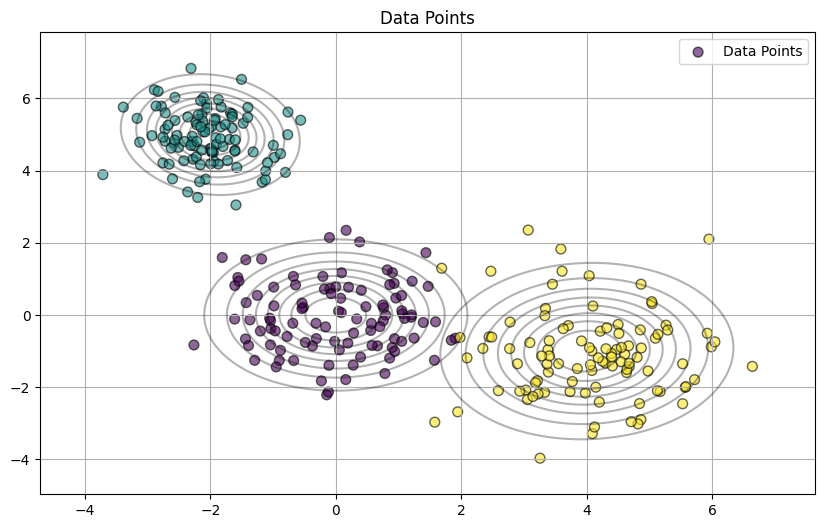

In [10]:
def visualize_data(data, means, covariances):

    """Visualize the data points with separate Gaussian distribution contours for each cluster."""

    fig, ax = plt.subplots(figsize = (10, 6))

    labels = data[:, 2]  # Extract labels from the last column of the dataset
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'viridis', alpha = 0.6, edgecolor = 'k', s = 50, label = 'Data Points')

    # Create a grid for contour plots
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    x, y = np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300)
    xx, yy = np.meshgrid(x, y)
    grid_data = np.column_stack([xx.ravel(), yy.ravel()])

    # Draw contours for each Gaussian distribution
    for i in range(len(means)):
        zz = multivariate_normal.pdf(grid_data, mean = means[i], cov = covariances[i]).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels = np.linspace(zz.min(), zz.max(), 10), colors = 'k', alpha = 0.3)

    # Plot formatting
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title('Data Points')
    ax.grid(True)
    ax.legend()
    plt.show()

visualize_data(data, means, covariances)

### 03. Gaussian Mixture Model


Gaussian Mixture Model은 크게 E-step과 M-step으로 이루어져서 EM 방식을 통해 동작한다.

이 점을 참고하여 아래 GMM 함수를 직접 실행하고 결과를 확인해보자!


[참고사항]

몇 가지 헷갈릴만한 질문 사항에 대한 답변들입니다!

1. **useProp은 무슨 변수인가요?**

   _클러스터의 가중치를 초기화하는 방법과 관련한 변수입니다. Dirichlet distribution을 사용할지 유무를 결정하게 됩니다._

   _사용하지 않을 경우는 동일한 비율로 가중치를 할당하게 됩니다._

   _useProp이 True인 경우 매 실행마다 mixing weight($w_{k}$)가 랜덤하게 달라져 이전과 다른 결과가 출력됩니다._

   _(Dirichlet distribution에 대한 설명: https://donghwa-kim.github.io/distributions.html)_

2. **fixedCovars는 무슨 변수인가요?**

   _각 클러스터의 공분산 행렬을 단위행렬으로 고정할지 유무를 결정하는 변수입니다._

   _기본적으로는 False로 선언하여, M-step에서 클러스터의 모양이 데이터에 맞게 변화할 수 있도록 설정합니다._


In [11]:
def GMM(data, means, hard = False, fixedCovars = False, useProp = True):
    N, D = data.shape  # N: number of data points, D: dimension of data points
    K = means.shape[0]  # K: number of clusters

    # Initialize weights
    if useProp:
        weights = np.random.dirichlet(alpha = np.ones(K))
    else:
        weights = np.full(K, 1/K)

    # Initialize covariances
    if fixedCovars:
        covariances = [np.eye(D) for _ in range(K)]
    else:
        covariances = [np.cov(data.T) + np.eye(D) * 1e-6 for _ in range(K)]

    assign_history = []
    means_history = [means.copy()]
    vars_history = [np.array(covariances)]

    convergence = False

    while not convergence:

        # E-step: Calculate responsibilities or hard assignments
        responsibilities = np.zeros((N, K))

        for k in range(K):
            mvn = multivariate_normal(means[k], covariances[k])
            responsibilities[:, k] = mvn.pdf(data) * weights[k]

        sum_responsibilities = responsibilities.sum(axis = 1)
        responsibilities /= sum_responsibilities[:, None]

        if hard:
            hard_assignments = np.argmax(responsibilities, axis = 1)
            responsibilities = np.zeros_like(responsibilities)
            responsibilities[np.arange(N), hard_assignments] = 1

        assign_history.append(np.argmax(responsibilities, axis = 1))

        # M-step: Update means and optionally covariances
        new_means = np.zeros_like(means)
        new_covariances = []

        for k in range(K):
            Nk = responsibilities[:, k].sum()
            new_means[k] = np.dot(responsibilities[:, k], data) / Nk

            if not fixedCovars:
                data_centered = data - new_means[k]
                cov_k = np.dot(responsibilities[:, k] * data_centered.T, data_centered) / Nk
                new_covariances.append(cov_k)
            else:
                new_covariances.append(np.eye(D))

        means_history.append(new_means)
        vars_history.append(new_covariances)

        # Check for convergence (means don't change)
        convergence = np.allclose(means, new_means)
        means = new_means
        covariances = new_covariances

    return assign_history, means_history, vars_history


In [12]:
def DrawGMM(data, assign_history, means_history, vars_history, colors, interval = 0.5):
    fig, ax = plt.subplots(figsize = (10, 6))

    initial_means = means_history[0]
    max_v = np.ceil(data.max(axis = 0))
    min_v = np.floor(data.min(axis = 0))
    mrg = (max_v - min_v).max() - (max_v - min_v) + 2
    max_v += mrg / 2
    min_v -= mrg / 2

    x_1 = np.linspace(min_v[0], max_v[0], 100, endpoint = False)
    x_2 = np.linspace(min_v[1], max_v[1], 100, endpoint = False)
    mesh_grid = np.array(np.meshgrid(x_1, x_2))
    grid_data = np.transpose(mesh_grid, (1, 2, 0)).reshape(-1, 2)

    for assign, means, vars in zip(assign_history, means_history, vars_history):
        ax.clear()
        prob_mesh = Gaussian2D(grid_data, means, vars).reshape(x_2.shape[0], x_1.shape[0], -1)
        ax.scatter(data[:, 0], data[:, 1], c=colors[assign], alpha=0.3)

        # ③ 매 프레임마다 초기 중심 마커로 표시
        ax.scatter(initial_means[:, 0],
                   initial_means[:, 1],
                   marker='x',
                   s=100,
                   c='k',
                   label='Initial Means')
        ax.legend()

        contour = ax.contour(x_1, x_2, np.max(prob_mesh, axis = 2))

        ax.set_xlim(min_v[0], max_v[0])
        ax.set_ylim(min_v[1], max_v[1])
        ax.grid(True)
        plt.draw()
        clear_output(wait = True)
        display(fig)
        time.sleep(interval)

    plt.close(fig)

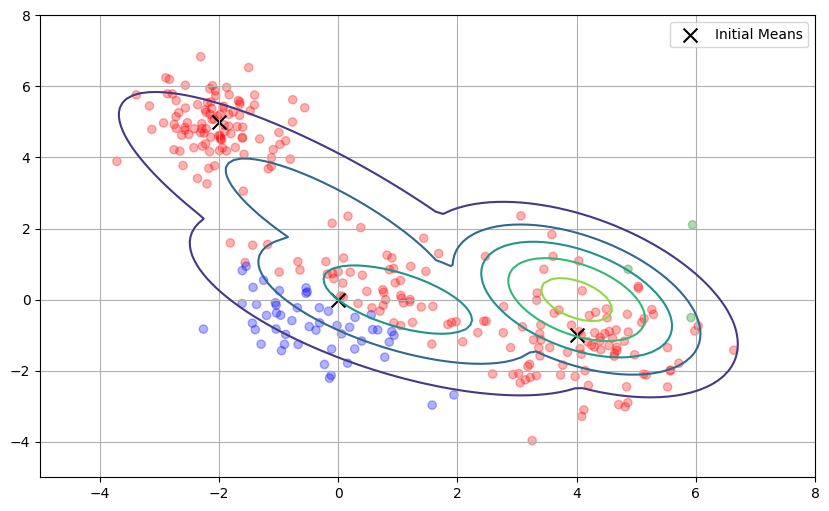

In [13]:
# Example usage
assign_history, means_history, vars_history = GMM(data[:, :2], means)
# Example usage
DrawGMM(data, assign_history, means_history, vars_history, colors = np.array(['b', 'r', 'g']), interval = 1)

### 04. Experiment


아래와 같은 data1, data2 2가지 데이터셋이 생성되었다고 가정해봅시다.

      1) Randomly Selected Centroids
      2) Manually Defined Centroids
      3) Centroids from K-means

위 3가지 각기다른 centroid 선택 방식에 따라 달라지는 GMM 실행 결과를 직접 확인해보세요!


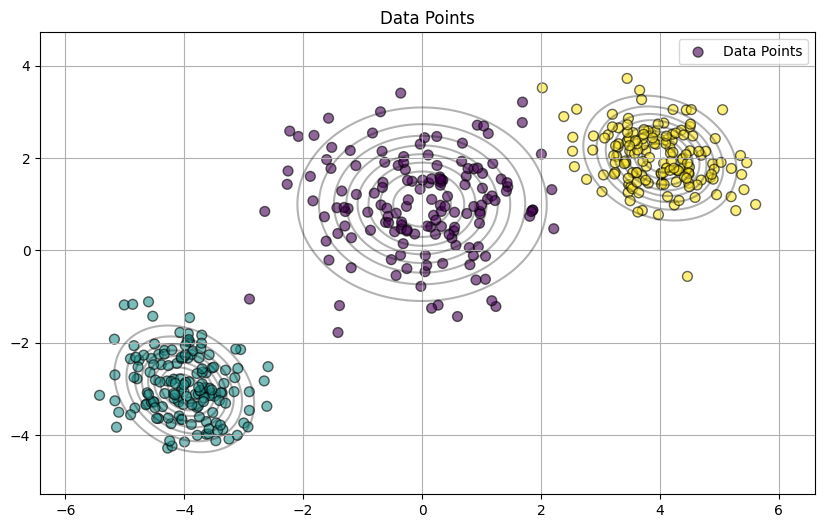

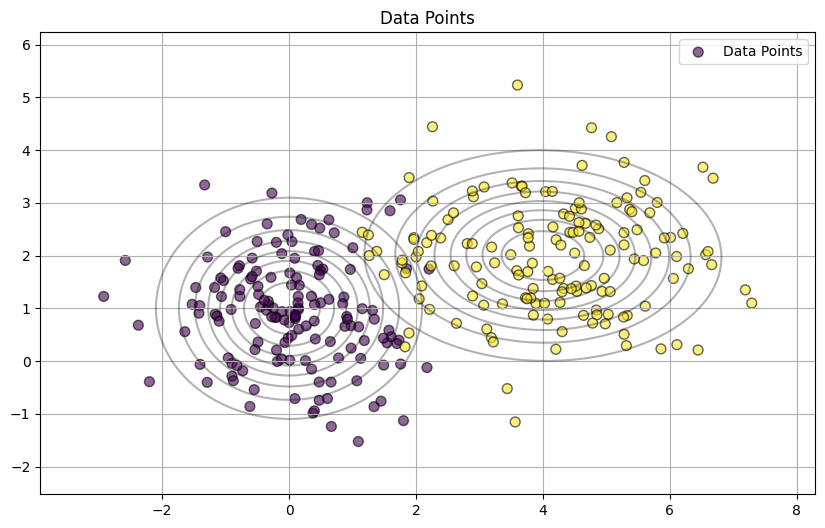

In [14]:
# Dataset generation
means1 = np.array([[0, 1], [-4, -3], [4, 2]])
data1, covariances1 = generate_dataset_2d(means1, n = 150, isotropic = True) # Set isotropic option True

# Visualize generated data
visualize_data(data1, means1, covariances1)

# Dataset generation
means2 = np.array([[0, 1], [4, 2]])
data2, covariances2 = generate_dataset_2d(means2, n = 150, isotropic = True) # Set isotropic option False

# Visualize generated data
visualize_data(data2, means2, covariances2)

In [15]:
# Set three random initial centroids
def initialize_centroids(data, k, method = 'random'):

    """
      Initial Centroids Selection
      1) Randomly Selected Centroids
      2) Manually Defined Centroids
      3) Centroids from K-means
    """

    if method == 'random':
        indices = np.random.choice(data.shape[0], k, replace = False)
        return data[indices]

    elif method == 'manual':
        if k == 3:
            return data[np.array([data.shape[0] // 4, (data.shape[0] // 4) * 2, (data.shape[0] // 4) * 3])]
        elif k == 2:
            return data[np.array([data.shape[0] // 3, (data.shape[0] // 3) * 2])]

    elif method == 'kmeans':
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(data)
        return kmeans.cluster_centers_

    else:
        return None

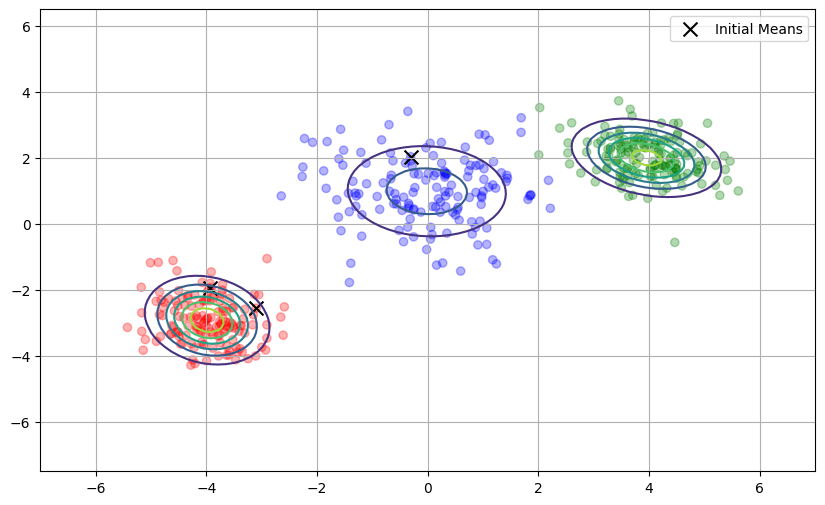

In [16]:
# Data1 : Random Initialization
assign_history_11, means_history_11, vars_history_11 = GMM(data1[:, :2], initialize_centroids(data1[:, :2], k = 3, method = 'random'))
DrawGMM(data1, assign_history_11, means_history_11, vars_history_11, colors = np.array(['b', 'r', 'g']), interval = 0.5)

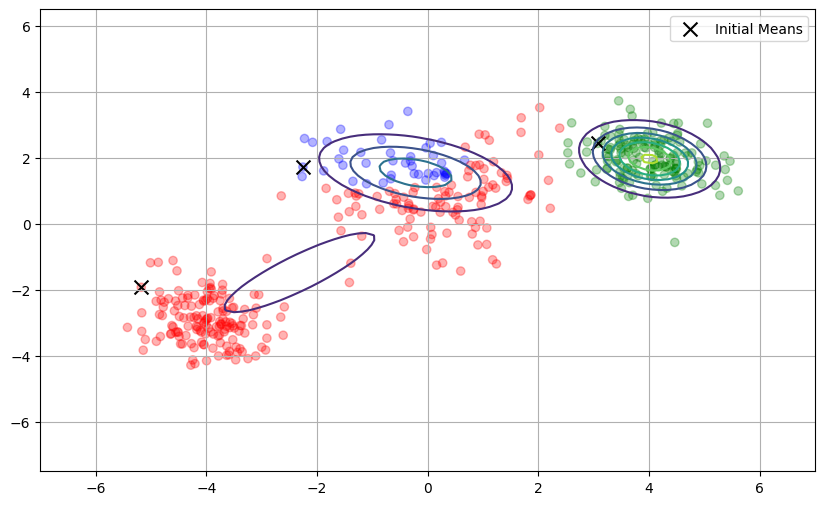

In [17]:
# Data1 : Manual Initialization
assign_history_12, means_history_12, vars_history_12 = GMM(data1[:, :2], initialize_centroids(data1[:, :2], k = 3, method = 'manual'))
DrawGMM(data1, assign_history_12, means_history_12, vars_history_12, colors = np.array(['b', 'r', 'g']), interval = 0.5)

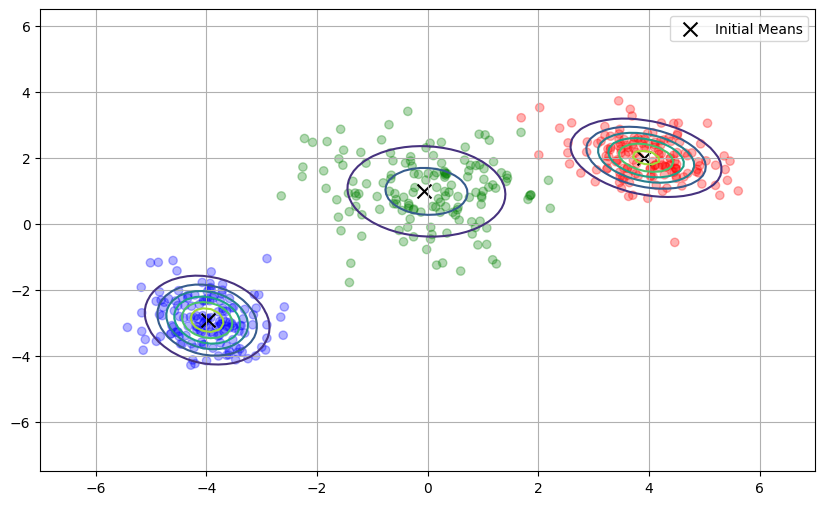

In [18]:
# Data1 : Kmeans Initialization
assign_history_13, means_history_13, vars_history_13 = GMM(data1[:, :2], initialize_centroids(data1[:, :2], k = 3, method = 'kmeans'))
DrawGMM(data1, assign_history_13, means_history_13, vars_history_13, colors = np.array(['b', 'r', 'g']), interval = 0.5)

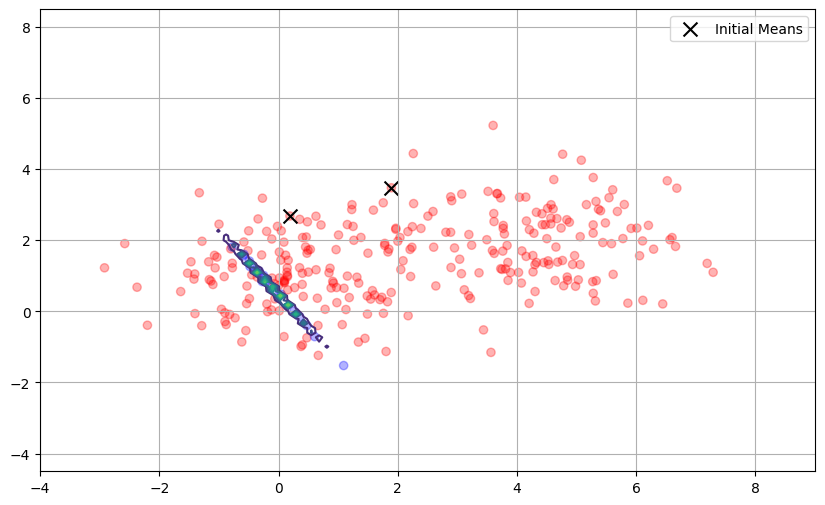

In [19]:
# Data2 : Random Initialization
assign_history_21, means_history_21, vars_history_21 = GMM(data2[:, :2], initialize_centroids(data2[:, :2], k = 2, method = 'random'))
DrawGMM(data2, assign_history_21, means_history_21, vars_history_21, colors = np.array(['b', 'r']), interval = 0.5)

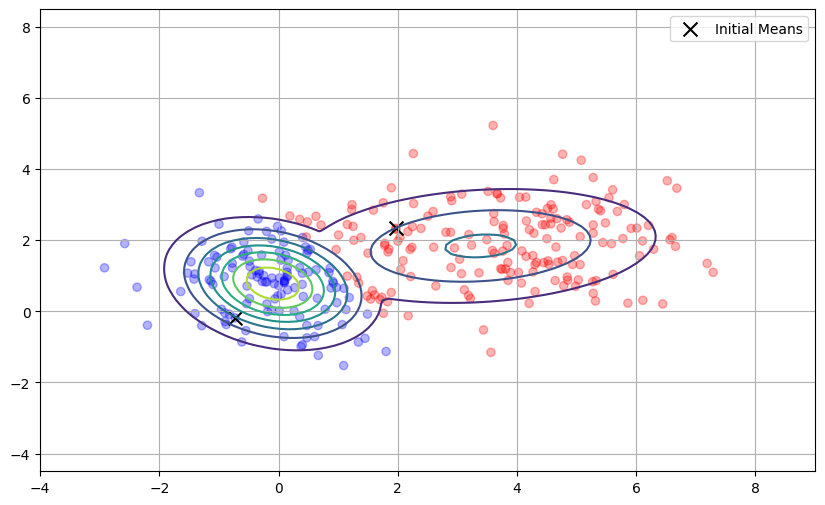

In [20]:
# Data2 : Manual Initialization
assign_history_22, means_history_22, vars_history_22 = GMM(data2[:, :2], initialize_centroids(data2[:, :2], k = 2, method = 'manual'))
DrawGMM(data2, assign_history_22, means_history_22, vars_history_22, colors = np.array(['b', 'r']), interval = 0.5)

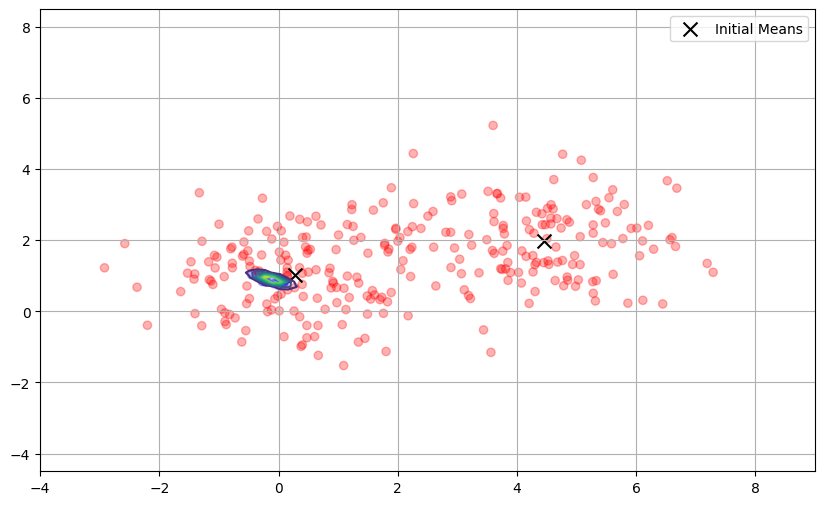

In [21]:
# Data2 : Kmeans Initialization
assign_history_23, means_history_23, vars_history_23 = GMM(data2[:, :2], initialize_centroids(data2[:, :2], k = 2, method = 'kmeans'))
DrawGMM(data2, assign_history_23, means_history_23, vars_history_23, colors = np.array(['b', 'r']), interval = 0.5)